In [2]:
import pandas as pd
import numpy as np

def merger_fire_climat(fire_path, climat_path, output_path):
    """
    Merge les fichiers fire.csv et climat.csv avec approximation 3 décimales
    Ajoute une colonne 'classe' : 1 si point de feu, 0 sinon
    """
    print("🔥🌦️  MERGE FIRE-CLIMAT AVEC APPROXIMATION 3 DÉCIMALES")
    print("=" * 60)
    
    # 1. Charger les données
    print("📁 Chargement des fichiers...")
    df_fire = pd.read_csv(fire_path)
    df_climat = pd.read_csv(climat_path)
    
    print(f"   • Feux: {len(df_fire):,} points")
    print(f"   • Points climatiques: {len(df_climat):,} points")
    
    # 2. Créer les colonnes arrondies temporaires
    print("\n🔄 Application de l'arrondi 3 décimales...")
    df_fire['lat_arr'] = df_fire['latitude'].round(3)
    df_fire['lon_arr'] = df_fire['longitude'].round(3)
    
    df_climat['lat_arr'] = df_climat['latitude'].round(3)
    df_climat['lon_arr'] = df_climat['longitude'].round(3)
    
    # 3. Merge avec indicator pour savoir quels points matchent
    print("🔗 Merge des données...")
    df_merge = pd.merge(
        df_climat,
        df_fire,  # On prend seulement les coords arrondies des feux
        on=['lat_arr', 'lon_arr'],
        how='outer',
        indicator=True  # Cette colonne nous dira quels points ont matché
    )
    
    # 4. Créer la colonne 'classe'
    print("🎯 Création de la colonne 'classe'...")
    df_merge['classe'] = (df_merge['_merge'] == 'both').astype(int)
    
    # 5. Supprimer les colonnes temporaires
    df_merge = df_merge.drop(['lat_arr', 'lon_arr', '_merge'], axis=1)
    
    # 6. Statistiques finales
    points_feu = df_merge['classe'].sum()
    pourcentage_feu = (points_feu / len(df_merge)) * 100
    
    print(f"\n✅ MERGE TERMINÉ !")
    print(f"📊 STATISTIQUES FINALES:")
    print(f"   • Points totaux: {len(df_merge):,}")
    print(f"   • Points avec classe=1 (feux): {points_feu:,}")
    print(f"   • Points avec classe=0 (non-feux): {len(df_merge) - points_feu:,}")
    print(f"   • Pourcentage de feux: {pourcentage_feu:.4f}%")
    print(f"   • Ratio déséquilibre: 1:{int((len(df_merge) - points_feu) / points_feu)}")
    
    # 7. Sauvegarder
    print(f"\n💾 Sauvegarde du fichier merge...")
    df_merge.to_csv(output_path, index=False)
    print(f"   📁 Fichier: {output_path}")
    
    return df_merge

# UTILISATION
df_final = merger_fire_climat(
    fire_path="csv_final/fires.csv",
    climat_path="csv_final/climat.csv", 
    output_path="csv_final/fire+climat.csv"
)

🔥🌦️  MERGE FIRE-CLIMAT AVEC APPROXIMATION 3 DÉCIMALES
📁 Chargement des fichiers...
   • Feux: 14,216 points
   • Points climatiques: 2,481,850 points

🔄 Application de l'arrondi 3 décimales...
🔗 Merge des données...
🎯 Création de la colonne 'classe'...

✅ MERGE TERMINÉ !
📊 STATISTIQUES FINALES:
   • Points totaux: 2,495,972
   • Points avec classe=1 (feux): 166
   • Points avec classe=0 (non-feux): 2,495,806
   • Pourcentage de feux: 0.0067%
   • Ratio déséquilibre: 1:15034

💾 Sauvegarde du fichier merge...
   📁 Fichier: csv_final/fire+climat.csv


In [17]:
import pandas as pd

# --- Configuration ---
FICHIER_POINTS = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\points.csv'
FICHIER_FIRES = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\fires.csv'
FICHIER_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\points+fires.csv'

# Noms de colonnes (doivent être les mêmes dans les deux fichiers après l'arrondi)
COL_LAT = 'latitude'
COL_LON = 'longitude'
# --------------------

print(f"Chargement des fichiers...")
df_points = pd.read_csv(FICHIER_POINTS)
df_fires = pd.read_csv(FICHIER_FIRES)

# S'assurer que les dataframes sont uniques sur les coordonnées avant le merge
# (Garder la première occurrence de chaque emplacement en cas de doublon)
df_points.drop_duplicates(subset=[COL_LAT, COL_LON], keep='first', inplace=True)
df_fires.drop_duplicates(subset=[COL_LAT, COL_LON], keep='first', inplace=True)

print(f"Taille de la grille (points.csv): {len(df_points)} points")
print(f"Taille des feux uniques (fires.csv): {len(df_fires)} points")

print("Fusion des jeux de données avec jointure externe...")

# 1. Effectuer la jointure externe (Outer Merge)
# Ceci garde TOUTES les lignes de df_points ET TOUTES les lignes de df_fires.
# Les colonnes de df_fires qui ne matchent pas (la plupart des colonnes de feu) seront suffixées par '_fire'.
# Nous ne gardons que les coordonnées de df_fires pour la jointure.
df_fusion = df_points.merge(
    df_fires[[COL_LAT, COL_LON]].assign(is_fire=1), # Ajout temporaire d'une colonne 'is_fire' à fires.csv
    on=[COL_LAT, COL_LON],
    how='outer', # Jointure externe pour inclure les points de feu non présents dans la grille
    indicator=True # Ajoute une colonne _merge pour vérifier l'origine
)

# 2. Créer la colonne 'classe'
df_fusion['classe'] = df_fusion['is_fire'].fillna(0).astype(int)

# 3. Supprimer la colonne temporaire 'is_fire'
df_fusion.drop(columns=['is_fire'], inplace=True)

# 4. Analyser le résultat de la fusion 

points_ajoutes = len(df_fusion[df_fusion['_merge'] == 'right_only'])
df_fusion.drop(columns=['_merge'], inplace=True) # Supprimer la colonne d'indicateur

print("\n--- Résultat de la fusion ---")
print(f"Nombre total de lignes dans le dataset final : {len(df_fusion)}")
print(f"Nombre de points de feu (classe=1) : {df_fusion['classe'].sum()}")
print(f"Nombre de points de feu ajoutés à la grille : {points_ajoutes}")
print(df_fusion['classe'].value_counts())

# Sauvegarder le fichier final
df_fusion.to_csv(FICHIER_FINAL, index=False)
print(f"\nLe dataset fusionné a été sauvegardé dans {FICHIER_FINAL}")

Chargement des fichiers...
Taille de la grille (points.csv): 2481850 points
Taille des feux uniques (fires.csv): 8841 points
Fusion des jeux de données avec jointure externe...

--- Résultat de la fusion ---
Nombre total de lignes dans le dataset final : 2490597
Nombre de points de feu (classe=1) : 8841
Nombre de points de feu ajoutés à la grille : 8747
classe
0    2481756
1       8841
Name: count, dtype: int64

Le dataset fusionné a été sauvegardé dans C:\Users\hp\Desktop\TPs\DataMining\csv_final\points+fires.csv


In [18]:
import pandas as pd

# --- Configuration Étape 1 ---
climat = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\climat.csv'
points_fires = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\points+fires.csv' # Le fichier maître avec les coordonnées et la colonne 'classe'
climat_points_feu = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\climat_points_feu.csv' # Le fichier intermédiaire avec les NaN
COL_LAT = 'latitude'
COL_LON = 'longitude'

CLIMATE_FEATURES = [
    'prec_hiver', 'prec_printemps', 'prec_ete', 'prec_automne',
    'tmin_hiver', 'tmin_printemps', 'tmin_ete', 'tmin_automne',
    'tmax_hiver', 'tmax_printemps', 'tmax_ete', 'tmax_automne'
]
# ------------------------------

print("--- ÉTAPE 1 : Fusion des Labels et des Features Climatiques ---")

# 1. Chargement des données
df_master = pd.read_csv(points_fires) # Le fichier maître avec la colonne 'classe'
df_climat_source = pd.read_csv(climat) # Le fichier source des features climatiques


# 3. Fusion à Gauche (Left Merge)
# Ceci ajoute les colonnes climatiques de df_climat_source à df_master.
# Les lignes dans df_master qui n'ont pas de correspondance dans df_climat_source
# (i.e., les points de feu ajoutés) recevront des NaN pour les features climatiques.
df_merge_nan = df_master.merge(
    df_climat_source,
    on=[COL_LAT, COL_LON],
    how='left', # Garde toutes les lignes de df_master
    suffixes=('_master', '_climat') # Pour éviter les conflits de colonnes non spécifiées
)

# 4. Vérification et Sauvegarde
nan_count = df_merge_nan[df_merge_nan['classe'] == 1][CLIMATE_FEATURES[0]].isna().sum()

print(f"Fichier intermédiaire créé : {climat_points_feu}.")
print(f"Lignes totales dans le dataset fusionné : {len(df_merge_nan)}.")
print(f"⚠️ Nombre de NaN à imputer (pour un feature climatique) : {nan_count}")

df_merge_nan.to_csv(climat_points_feu, index=False)

--- ÉTAPE 1 : Fusion des Labels et des Features Climatiques ---
Fichier intermédiaire créé : C:\Users\hp\Desktop\TPs\DataMining\csv_final\climat_points_feu.csv.
Lignes totales dans le dataset fusionné : 2490597.
⚠️ Nombre de NaN à imputer (pour un feature climatique) : 8747


In [19]:
import pandas as pd
import numpy as np # Utilisé pour le nettoyage initial

# --- Configuration (Identique) ---
FICHIER_MERGE_NAN = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\climat_points_feu.csv' 
FICHIER_CLIMAT = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\climat.csv'
FICHIER_FINAL_IMPUTE = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_impute.csv'

COL_LAT = 'latitude'
COL_LON = 'longitude'

# 🛑 CORRECTION MAJEURE : Mettre la première lettre en majuscule (Tmin, Tmax) 
# pour correspondre à la casse de votre fichier CSV.
CLIMATE_FEATURES_ALL = [
    'prec_hiver', 'prec_printemps', 'prec_ete', 'prec_automne',
    'tmin_hiver', 'tmin_printemps', 'tmin_ete', 'tmin_automne',
    'tmax_hiver', 'tmax_printemps', 'tmax_ete', 'tmax_automne'
]
# ------------------------------
# ------------------------------

print("\n--- ÉTAPE 2 : Imputation par Jointure d'ID de Grille ---")

# 1. Préparation de la Source (climat.csv)
df_climat_source = pd.read_csv(FICHIER_CLIMAT)
for col in [COL_LAT, COL_LON] + CLIMATE_FEATURES:
    df_climat_source[col] = pd.to_numeric(df_climat_source[col], errors='coerce')
    
# Arrondir et créer l'ID dans la source
df_climat_source[COL_LAT] = df_climat_source[COL_LAT].round(3)
df_climat_source[COL_LON] = df_climat_source[COL_LON].round(3)

# Création de l'ID de grille unique (clé de jointure)
df_climat_source['grid_id'] = df_climat_source[COL_LAT].astype(str) + '_' + df_climat_source[COL_LON].astype(str)
# Sélectionner uniquement les colonnes d'ID et les features pour la source de jointure
df_climat_lookup = df_climat_source[['grid_id'] + CLIMATE_FEATURES].drop_duplicates(subset=['grid_id'])

# 2. Préparation du Fichier Fusionné (Cible)
df_fusion = pd.read_csv(FICHIER_MERGE_NAN)
for col in [COL_LAT, COL_LON]:
    df_fusion[col] = pd.to_numeric(df_fusion[col], errors='coerce')
    
# Créer l'ID de grille dans la cible
df_fusion['grid_id'] = df_fusion[COL_LAT].round(3).astype(str) + '_' + df_fusion[COL_LON].round(3).astype(str)

# 3. Imputation par Jointure à Gauche
print("Imputation des NaN par jointure sur 'grid_id'...")

# Effectuer la jointure : ajouter les colonnes climatiques de la source (lookup) à la cible (fusion)
df_fusion.drop(columns=CLIMATE_FEATURES, errors='ignore', inplace=True) # Supprimer les colonnes existantes pour éviter le suffixe _x, _y

df_final = df_fusion.merge(
    df_climat_lookup,
    on='grid_id',
    how='left'
)

# 4. Nettoyage et Vérification
df_final.drop(columns=['grid_id'], inplace=True)

# Vérification finale
nan_count = df_final[df_final['classe'] == 1][CLIMATE_FEATURES[0]].isna().sum()

if nan_count == 0:
    df_final.to_csv(FICHIER_FINAL_IMPUTE, index=False)
    print(f"\n✅ Succès : Imputation terminée par ID de grille. Le dataset final est prêt : {FICHIER_FINAL_IMPUTE}")
    print(f"Total des lignes : {len(df_final)}")
else:
    print(f"\n❌ Erreur : {nan_count} NaN subsistent après la jointure. Cela indique des points de feu (classe=1) dont l'ID de grille n'a aucun correspondant dans climat.csv.")


--- ÉTAPE 2 : Imputation par Jointure d'ID de Grille ---
Imputation des NaN par jointure sur 'grid_id'...

❌ Erreur : 8747 NaN subsistent après la jointure. Cela indique des points de feu (classe=1) dont l'ID de grille n'a aucun correspondant dans climat.csv.


In [20]:
import pandas as pd

# --- Configuration des Fichiers ---
FICHIER_FINAL = r'C:\Users\hp\Desktop\TPs\DataMining\csv_final\climat_points_feu.csv'
FICHIER_COORDONNEES_CIBLES = r'C:\Users\hp\Desktop\TPs\DataMining\csv_final\coords_a_imputer.csv' # Nouveau fichier intermédiaire
FEAT_EXAMPLE = 'prec_hiver' # Colonne de référence pour trouver les NaN
COL_LAT = 'latitude'
COL_LON = 'longitude'
# ----------------------------------

print("--- ÉTAPE 1 : Isolation des Coordonnées Cibles ---")

# 1. Chargement et Identification des NaN
df_final = pd.read_csv(FICHIER_FINAL)
nan_mask = df_final[FEAT_EXAMPLE].isna()

# 2. Extraction des coordonnées uniques des points à imputer
df_targets_coords = df_final[nan_mask][[COL_LON, COL_LAT]].drop_duplicates()

if df_targets_coords.empty:
    print("✅ Aucune valeur NaN n'a été trouvée. Le fichier est déjà complet.")
    # Sortir ici ou copier le fichier final
else:
    # 3. Sauvegarde des coordonnées dans un CSV
    df_targets_coords.to_csv(FICHIER_COORDONNEES_CIBLES, index=False)
    print(f"✅ Identifié {len(df_targets_coords)} coordonnées uniques à imputer.")
    print(f"   Sauvegardé dans : {FICHIER_COORDONNEES_CIBLES}")

--- ÉTAPE 1 : Isolation des Coordonnées Cibles ---
✅ Identifié 8770 coordonnées uniques à imputer.
   Sauvegardé dans : C:\Users\hp\Desktop\TPs\DataMining\csv_final\coords_a_imputer.csv


In [21]:
import rasterio
import os
import numpy as np

# --- Configuration Raster et Saisons ---
BASE_DIR = r'C:\Users\hp\Desktop\TPs\DataMining\DATA\Climate' 
FICHIER_IMPUTATION_DATA = 'new_climate_data.csv' # Fichier de sortie de cette étape

ATTRIBUTES = ['prec', 'tmin', 'tmax']
MONTHS = [f'{i:02d}' for i in range(1, 13)] 

SAISONS = {
    'hiver': ['01', '02', '12'], # Basé sur 2024-01, 2024-02, 2024-12
    'printemps': ['03', '04', '05'],
    'ete': ['06', '07', '08'],
    'automne': ['09', '10', '11']
}
# ----------------------------------------

print("\n--- ÉTAPE 2 : Extraction et Calculs Saisonniers ---")

# 1. Chargement des coordonnées cibles
df_targets_coords = pd.read_csv(FICHIER_COORDONNEES_CIBLES)
coords_for_sampling = list(zip(df_targets_coords[COL_LON], df_targets_coords[COL_LAT]))

# DataFrame pour stocker les résultats
df_imputation_data = df_targets_coords.copy()

for attr in ATTRIBUTES:
    monthly_data = {}
    
    # 2.1 Extraction Mois par Mois
    for month in MONTHS:
        attr_capitalized = attr.capitalize()
        file_name = f'wc2.1_cruts4.09_5m_{attr}_2024-{month}.tif'
        raster_path = os.path.join(BASE_DIR, attr_capitalized, file_name)
        
        if not os.path.exists(raster_path):
            continue
            
        try:
            with rasterio.open(raster_path) as src:
                extracted_values = [val[0] for val in src.sample(coords_for_sampling)]
                monthly_data[month] = extracted_values
        except Exception as e:
            print(f"❌ Erreur lors de l'extraction pour {attr} {month}: {e}")

    # 2.2 Calcul des Moyennes Saisonnières
    if not monthly_data:
        print(f"⚠️ Aucune donnée mensuelle trouvée pour l'attribut {attr}.")
        continue

    df_monthly = pd.DataFrame(monthly_data)
    
    for season_name, months_list in SAISONS.items():
        valid_months = [m for m in months_list if m in df_monthly.columns]
        
        if valid_months:
            season_mean = df_monthly[valid_months].mean(axis=1)
            
            # 🛑 CRITIQUE : Nous utilisons la casse EXACTE du fichier final ici (Tmin, Tmax)
            # pour éviter les KeyErrors à l'étape 3.
            if attr == 'tmin':
                new_col_name = f'Tmin_{season_name}'
            elif attr == 'tmax':
                new_col_name = f'Tmax_{season_name}'
            else:
                new_col_name = f'prec_{season_name}'
                
            df_imputation_data[new_col_name] = season_mean
            
# 3. Sauvegarde des données imputées
df_imputation_data.to_csv(FICHIER_IMPUTATION_DATA, index=False)
print(f"✅ Données climatiques calculées sauvegardées dans : {FICHIER_IMPUTATION_DATA}")


--- ÉTAPE 2 : Extraction et Calculs Saisonniers ---
✅ Données climatiques calculées sauvegardées dans : new_climate_data.csv


In [22]:
import pandas as pd
import numpy as np
import os 

# --- Configuration de la Refusion (Identique) ---
FICHIER_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\climat_points_feu.csv' 
FICHIER_NEW_CLIMATE = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\new_climate_data.csv' # Fichier contenant les données extraites
FICHIER_FINAL_IMPUTE = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_impute_ok.csv' 

COL_LAT = 'latitude'
COL_LON = 'longitude'

CLIMATE_FEATURES_ALL = [
    'prec_hiver', 'prec_printemps', 'prec_ete', 'prec_automne',
    'tmin_hiver', 'tmin_printemps', 'tmin_ete', 'tmin_automne',
    'tmax_hiver', 'tmax_printemps', 'tmax_ete', 'tmax_automne'
]
# ------------------------------------

print("\n--- ÉTAPE 3 (CORRIGÉE) : Imputation par Remplacement CIBLÉ ---")

# 1. Chargement et Préparation des données
try:
    df_final = pd.read_csv(FICHIER_FINAL)
    df_new_climate = pd.read_csv(FICHIER_NEW_CLIMATE)
except FileNotFoundError as e:
    print(f"Erreur: Un fichier est manquant. {e}")
    exit() 

# 2. Harmonisation des clés de jointure (Arrondi)
# L'arrondi est crucial pour que la jointure trouve les correspondances
df_final[COL_LON] = df_final[COL_LON].round(3)
df_final[COL_LAT] = df_final[COL_LAT].round(3)
df_new_climate[COL_LON] = df_new_climate[COL_LON].round(3)
df_new_climate[COL_LAT] = df_new_climate[COL_LAT].round(3)

# 3. Préparation des Données d'Imputation
# Réduire le nouveau fichier aux clés de jointure et aux features climatiques
COLS_TO_KEEP = [COL_LON, COL_LAT] + CLIMATE_FEATURES_ALL
df_new_climate_lookup = df_new_climate[COLS_TO_KEEP].drop_duplicates(subset=[COL_LON, COL_LAT])


# 4. Refusion (Left Merge pour obtenir les nouvelles valeurs dans le fichier final)
# Nous joignons les nouvelles données climatiques, elles auront le suffixe '_new'
df_final_merged = df_final.merge(
    df_new_climate_lookup,
    on=[COL_LON, COL_LAT],
    how='left',
    suffixes=('', '_new') # Le suffixe est appliqué à la source (new_climate)
)

# 5. Imputation Ciblée (Remplacement des NaN)
print("Remplacement des NaN par les nouvelles valeurs extraites...")

for feature in CLIMATE_FEATURES_ALL:
    col_new = f'{feature}_new'
    
    # Remplacer les NaN de la colonne originale par les valeurs de la colonne jointée (col_new)
    # Si la colonne originale n'était pas NaN, fillna ne fait rien, préservant les données existantes.
    df_final_merged[feature].fillna(df_final_merged[col_new], inplace=True)
    
    # Une fois l'imputation effectuée, supprimer la colonne temporaire jointée
    df_final_merged.drop(columns=[col_new], inplace=True)

# 6. Vérification finale
nan_final_count = df_final_merged[df_final_merged['classe'] == 1][CLIMATE_FEATURES_ALL[0]].isna().sum()

if nan_final_count == 0:
    df_final_merged.to_csv(FICHIER_FINAL_IMPUTE, index=False)
    print(f"\n✅ Succès : L'imputation est terminée. Les données existantes ont été conservées.")
    print(f"Le fichier final est : {FICHIER_FINAL_IMPUTE}")
    print(f"Total des lignes : {len(df_final_merged)}")
else:
    df_final_merged.to_csv(FICHIER_FINAL_IMPUTE, index=False)
    print(f"\n❌ Échec : {nan_final_count} NaN subsistent après l'imputation. Il y a un problème de jointure (arrondi ou coordonnées non correspondantes).")


--- ÉTAPE 3 (CORRIGÉE) : Imputation par Remplacement CIBLÉ ---
Remplacement des NaN par les nouvelles valeurs extraites...


C:\Users\hp\AppData\Local\Temp\ipykernel_10024\3988588126.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final_merged[feature].fillna(df_final_merged[col_new], inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_10024\3988588126.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 


✅ Succès : L'imputation est terminée. Les données existantes ont été conservées.
Le fichier final est : C:\Users\hp\Desktop\TPs\DataMining\csv_final\dataset_final_impute_ok.csv
Total des lignes : 2490597


In [23]:
import pandas as pd
import numpy as np

# --- Configuration des Fichiers et des Colonnes ---
FICHIER_ENTREE_NAN = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_impute_ok.csv' 
FICHIER_SORTIE_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_complet_ORDONNE_FINAL.csv' # Fichier de sortie final

COL_LAT = 'latitude'
COL_LON = 'longitude'

CLIMATE_FEATURES = [
    'prec_hiver', 'prec_printemps', 'prec_ete', 'prec_automne',
    'tmin_hiver', 'tmin_printemps', 'tmin_ete', 'tmin_automne',
    'tmax_hiver', 'tmax_printemps', 'tmax_ete', 'tmax_automne'
]
# ---------------------------------------------------

try:
    # 1. Chargement et Sauvegarde de l'Ordre Original
    df = pd.read_csv(FICHIER_ENTREE_NAN)
    
    # 🛑 ÉTAPE CRUCIALE 1/3 : Sauvegarde de la position initiale de chaque ligne
    df['original_index'] = df.index 
    
    initial_nan_count = df[df['classe'] == 1][CLIMATE_FEATURES[0]].isna().sum()
    print(f"Dataset chargé. Nombre initial de NaN à imputer : {initial_nan_count}")
    
    if initial_nan_count != 0:
        # 2. Tri Géographique Fonctionnel et Imputation
        print("-> Tri du dataset par coordonnées pour l'imputation...")
        df.sort_values(by=[COL_LAT, COL_LON], inplace=True)

        print("-> Imputation des NaN restants par ffill/bfill...")
        for feature in CLIMATE_FEATURES:
            df[feature].fillna(method='ffill', inplace=True)
            df[feature].fillna(method='bfill', inplace=True)

        # 3. Restauration de l'Ordre Original
        print("-> Restauration de l'ordre original avant sauvegarde...")
        
        # 🛑 ÉTAPE CRUCIALE 2/3 : Trier le DataFrame sur l'index sauvegardé pour rétablir l'ordre
        df.sort_values(by='original_index', inplace=True)

        # Supprimer la colonne temporaire
        df.drop(columns=['original_index'], inplace=True)
        
        # 🛑 ÉTAPE CRUCIALE 3/3 : S'assurer que le nouvel index est séquentiel (0, 1, 2...)
        # Le DataFrame est maintenant dans l'ordre de ses lignes initiales
        df.reset_index(drop=True, inplace=True) 

        # 4. Vérification Finale et Sauvegarde
        final_nan_count = df[df['classe'] == 1][CLIMATE_FEATURES[0]].isna().sum()
        
        if final_nan_count == 0:
            df.to_csv(FICHIER_SORTIE_FINAL, index=False)
            print("\n✅ Succès : Le dataset est complet, et l'ordre des lignes original est restauré.")
            print(f"Fichier sauvegardé : {FICHIER_SORTIE_FINAL}")
        else:
            print(f"\n❌ ERREUR : {final_nan_count} NaN subsistent. L'imputation n'a pas été complète.")
    
except FileNotFoundError:
    print(f"❌ Erreur : Le fichier d'entrée '{FICHIER_ENTREE_NAN}' n'a pas été trouvé.")
except Exception as e:
    print(f"Une erreur inattendue est survenue : {e}")

Dataset chargé. Nombre initial de NaN à imputer : 0


In [24]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
FICHIER_CSV = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_impute_ok.csv' # 🛑 Remplacez ceci par le chemin réel de votre fichier
# --------------------

print(f"--- Analyse du Fichier : {os.path.basename(FICHIER_CSV)} ---")

try:
    # 1. Chargement du fichier
    df = pd.read_csv(FICHIER_CSV)
    total_lignes = len(df)
    print(f"Chargement réussi. Total des lignes : {total_lignes}")
    
    # 2. Vérification des NaN par colonne
    nan_par_colonne = df.isnull().sum()
    
    # Filtrer uniquement les colonnes ayant au moins un NaN
    colonnes_a_imputer = nan_par_colonne[nan_par_colonne > 0]
    
    if colonnes_a_imputer.empty:
        print("\n✅ Aucune valeur manquante ('NaN') détectée dans le jeu de données. Aucune imputation nécessaire.")
    else:
        print("\n❌ VALEURS MANQUANTES DÉTECTÉES. Imputation requise.")
        print("\n--- Détail par Colonne ---")
        
        # Afficher le compte des NaN et le pourcentage par colonne
        df_nan_info = pd.DataFrame({
            'Count': colonnes_a_imputer,
            'Percentage': (colonnes_a_imputer / total_lignes * 100).round(2).astype(str) + '%'
        })
        print(df_nan_info)
        
        # 3. Vérification des Lignes Complètes (pour voir l'impact)
        # Compter les lignes qui contiennent au moins un NaN dans n'importe quelle colonne
        lignes_avec_nan = total_lignes - len(df.dropna(how='any'))
        
        print("\n--- Synthèse de l'Imputation ---")
        print(f"Nombre total de NaN (toutes colonnes confondues) : {colonnes_a_imputer.sum()}")
        print(f"Nombre de lignes qui contiennent au moins un NaN : **{lignes_avec_nan}**")
        
        # 4. Conclusion
        taux_impact = (lignes_avec_nan / total_lignes * 100).round(2)
        print(f"Taux d'impact sur les lignes : {taux_impact}%")

        if taux_impact < 5:
            print("💡 Le taux d'impact est faible (< 5%). L'imputation simple (moyenne, ffill) ou la suppression des lignes manquantes est acceptable.")
        else:
            print("⚠️ Le taux d'impact est élevé. Une analyse plus poussée ou une imputation sophistiquée (modèle prédictif) est recommandée.")
        
except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier d'entrée '{FICHIER_CSV}' n'a pas été trouvé. Veuillez vérifier le chemin.")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")

--- Analyse du Fichier : dataset_final_impute_ok.csv ---
Chargement réussi. Total des lignes : 2490597

❌ VALEURS MANQUANTES DÉTECTÉES. Imputation requise.

--- Détail par Colonne ---
                Count Percentage
prec_hiver         22       0.0%
prec_printemps     22       0.0%
prec_ete           22       0.0%
prec_automne       22       0.0%
tmin_hiver         22       0.0%
tmin_printemps     22       0.0%
tmin_ete           22       0.0%
tmin_automne       22       0.0%
tmax_hiver         22       0.0%
tmax_printemps     22       0.0%
tmax_ete           22       0.0%
tmax_automne       22       0.0%

--- Synthèse de l'Imputation ---
Nombre total de NaN (toutes colonnes confondues) : 264
Nombre de lignes qui contiennent au moins un NaN : **22**

❌ Une erreur inattendue est survenue : 'float' object has no attribute 'round'


In [25]:
import pandas as pd

# 1. Configuration
FICHIER_CSV = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\climat.csv' # 🛑 Remplacez ceci par le chemin réel de votre fichier
# --------------------

try:
    # 2. Chargement du fichier
    df = pd.read_csv(FICHIER_CSV)
    
    # 3. Création du masque de lignes manquantes
    # df.isnull(): Crée un DataFrame de True/False (True si NaN)
    # .any(axis=1): Vérifie si VRAI (True) apparaît dans N'IMPORTE QUELLE colonne (axis=1 pour ligne)
    masque_nan = df.isnull().any(axis=1)
    
    # 4. Filtrage du DataFrame
    lignes_manquantes_df = df[masque_nan]
    
    print(f"--- Lignes Contenant des Valeurs Manquantes ---")
    
    if lignes_manquantes_df.empty:
        print("\n✅ Aucune ligne ne contient de valeur manquante (NaN).")
    else:
        print(f"\nTotal de lignes avec au moins un NaN : {len(lignes_manquantes_df)}")
        print("\nVoici les lignes qui contiennent des NaN (les premières 10 lignes affichées) :")
        
        # Afficher les premières lignes trouvées pour inspection
        print(lignes_manquantes_df.head(10).to_markdown(index=False))
        
        # Optionnel : Sauvegarder ces lignes dans un nouveau fichier CSV pour analyse
        # lignes_manquantes_df.to_csv('lignes_a_verifier.csv', index=False)
        
except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier d'entrée '{FICHIER_CSV}' n'a pas été trouvé.")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")

--- Lignes Contenant des Valeurs Manquantes ---

Total de lignes avec au moins un NaN : 23

Voici les lignes qui contiennent des NaN (les premières 10 lignes affichées) :
|   longitude |   latitude |   prec_hiver |   prec_printemps |   prec_ete |   prec_automne |   tmin_hiver |   tmin_printemps |   tmin_ete |   tmin_automne |   tmax_hiver |   tmax_printemps |   tmax_ete |   tmax_automne |
|------------:|-----------:|-------------:|-----------------:|-----------:|---------------:|-------------:|-----------------:|-----------:|---------------:|-------------:|-----------------:|-----------:|---------------:|
|      10.83  |     33.501 |          nan |              nan |        nan |            nan |          nan |              nan |        nan |            nan |          nan |              nan |        nan |            nan |
|      10.81  |     33.512 |          nan |              nan |        nan |            nan |          nan |              nan |        nan |            nan |          

In [27]:
import pandas as pd
import rasterio
import numpy as np
import os

# --- CONFIGURATION DES CHEMINS ---
# Votre fichier de données fusionné (points + feux)
FICHIER_ENTREE_POINTS = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\points+fires.csv'
FICHIER_SORTIE_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_avec_altitude.csv'

# 🛑 CHEMIN CRUCIAL : Pointez vers le fichier de données (w001001.adf) dans votre dossier ESRI Grid
CHEMIN_MNT = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\DATA\\Elevation\\be15_grd\\w001001.adf' 

COL_LAT = 'latitude'
COL_LON = 'longitude'
COL_ALT = 'altitude' # Nom de la nouvelle colonne
# --------------------------------

print(f"--- 🗺️ Démarrage de l'Extraction d'Altitude ---")

try:
    # 1. Chargement des données
    df = pd.read_csv(FICHIER_ENTREE_POINTS)
    print(f"Fichier chargé. Total des points à traiter : {len(df)}")
    
    # 2. Préparation des coordonnées pour l'échantillonnage Rasterio
    # Rasterio attend une liste de tuples (Longitude, Latitude)
    coords = list(zip(df[COL_LON], df[COL_LAT]))

    # 3. Extraction des valeurs du Raster
    altitudes = []
    
    with rasterio.open(CHEMIN_MNT) as src:
        print(f"Ouverture du MNT réussie. CRS du raster : {src.crs}")
        
        # Valeur NoData du raster (si non trouvée, utilisation d'une valeur par défaut courante)
        nodata_value = src.nodata if src.nodata is not None else -9999
        
        # 3.1. Effectuer l'échantillonnage de chaque point
        for val in src.sample(coords):
            alt = val[0]
            
            # 3.2. Remplacer les valeurs NoData par NaN
            if np.isclose(alt, nodata_value) or alt < nodata_value:
                altitudes.append(np.nan)
            else:
                altitudes.append(alt)
                
    # 4. Ajout de la nouvelle colonne
    df[COL_ALT] = altitudes
    
    # 5. Gestion des NaN résiduels (Points hors couverture)
    nan_altitude_count = df[COL_ALT].isna().sum()
    
    if nan_altitude_count > 0:
        print(f"\n⚠️ {nan_altitude_count} points d'altitude sont manquants (hors couverture du MNT).")
        print("-> Imputation par la méthode du voisin le plus proche (ffill/bfill)...")
        '''
        # L'imputation ffill/bfill est sécuritaire ici car les points manquants sont marginaux.
        df[COL_ALT].fillna(method='ffill', inplace=True)
        df[COL_ALT].fillna(method='bfill', inplace=True)
        
        # S'assurer que tous les NaN ont été imputés
        if df[COL_ALT].isnull().sum() == 0:
            print("   Imputation réussie. Tous les NaN ont été traités.")
        else:
            print("   Attention : Certains NaN subsistent (points isolés).")
        '''
    # 6. Sauvegarde du fichier final
    df.to_csv(FICHIER_SORTIE_FINAL, index=False)
    print(f"\n✅ Extraction terminée. Le fichier final a été sauvegardé avec la colonne '{COL_ALT}' : {FICHIER_SORTIE_FINAL}")

except rasterio.RasterioIOError:
    print(f"\n❌ ERREUR FATALE : Impossible d'ouvrir le fichier raster à {CHEMIN_MNT}.")
    print("Vérifiez que le chemin est exact et que le fichier 'w001001.adf' existe et n'est pas utilisé.")
except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier CSV d'entrée '{FICHIER_ENTREE_POINTS}' n'a pas été trouvé.")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")

--- 🗺️ Démarrage de l'Extraction d'Altitude ---
Fichier chargé. Total des points à traiter : 2490597
Ouverture du MNT réussie. CRS du raster : EPSG:4326

✅ Extraction terminée. Le fichier final a été sauvegardé avec la colonne 'altitude' : C:\Users\hp\Desktop\TPs\DataMining\csv_final\dataset_final_avec_altitude.csv


In [ ]:
import pandas as pd
import os

# --- CONFIGURATION DES CHEMINS ---
# Fichier 1 (Altitude) : Votre fichier le plus récent
FICHIER_ALTITUDE = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_avec_altitude.csv'

# Fichier 2 (Climat) : Votre fichier contenant les données climatiques
FICHIER_CLIMAT = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\fires+climat.csv' 

FICHIER_FINAL_MODELE = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_pour_modele.csv'

COL_LAT = 'latitude'
COL_LON = 'longitude'
# --------------------------------

print(f"--- 🚀 Démarrage de la Fusion Finale (Altitude + Climat) ---")

try:
    # 1. Chargement des données
    df_alt = pd.read_csv(FICHIER_ALTITUDE)
    df_climat = pd.read_csv(FICHIER_CLIMAT)
    
    # 2. Harmonisation des clés de jointure (Arrondi)
    # Assurer que les clés correspondent, comme vous l'avez fait précédemment
    for df in [df_alt, df_climat]:
        df[COL_LON] = df[COL_LON].round(3)
        df[COL_LAT] = df[COL_LAT].round(3)

    # 3. Préparation du fichier climat (Sélection des colonnes uniques)
    # On garde toutes les colonnes climatiques et on s'assure qu'elles sont uniques sur les coordonnées.
    # On exclut la colonne 'classe' du fichier climat car elle existe déjà dans le fichier altitude
    # et doit être identique après la première fusion.
    
    # Identifier les colonnes climatiques dans le fichier climat (tout sauf lat/lon/classe)
    cols_to_merge = [col for col in df_climat.columns if col not in [COL_LAT, COL_LON, 'classe']]
    
    # Ajouter les clés de jointure
    cols_to_merge = [COL_LAT, COL_LON, 'classe'] + cols_to_merge 
    
    # Réduire le DataFrame Climat aux colonnes nécessaires
    df_climat_subset = df_climat[cols_to_merge].drop_duplicates(subset=[COL_LAT, COL_LON])
    
    # 4. Fusion (Jointure Gauche)
    # df_alt devient la référence pour conserver l'ordre et toutes ses lignes
    df_final = df_alt.merge(
        df_climat_subset,
        on=[COL_LAT, COL_LON, 'classe'], # On joint sur les coordonnées ET la classe (qui doit être la même)
        how='left' 
    )

    # 5. Vérification Finale
    # Assurez-vous qu'aucune valeur climatique ne manque après la fusion (elles ne devraient pas)
    nan_count = df_final.isnull().sum().sum()
    
    print("\n--- Résultat de la Fusion ---")
    print(f"Total des lignes : {len(df_final)}")
    
    if nan_count == 0:
        print("✅ Succès : Le dataset final est complet et ne contient AUCUN NaN.")
    else:
        print(f"⚠️ Attention : {nan_count} NaN subsistent. Veuillez vérifier les colonnes pour trouver la source.")
        print("Détail des NaN par colonne:")
        print(df_final.isnull().sum()[df_final.isnull().sum() > 0])


    # 6. Sauvegarde du fichier final
    df_final.to_csv(FICHIER_FINAL_MODELE, index=False)
    print(f"\nLe dataset final prêt pour la modélisation a été sauvegardé : {FICHIER_FINAL_MODELE}")


except FileNotFoundError as e:
    print(f"\n❌ Erreur : Un des fichiers d'entrée est manquant : {e}")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")

--- 🚀 Démarrage de la Fusion Finale (Altitude + Climat) ---

--- Résultat de la Fusion ---
Total des lignes : 2490597
⚠️ Attention : 264 NaN subsistent. Veuillez vérifier les colonnes pour trouver la source.
Détail des NaN par colonne:
prec_hiver        22
prec_printemps    22
prec_ete          22
prec_automne      22
tmin_hiver        22
tmin_printemps    22
tmin_ete          22
tmin_automne      22
tmax_hiver        22
tmax_printemps    22
tmax_ete          22
tmax_automne      22
dtype: int64


In [2]:
import pandas as pd

# --- CONFIGURATION DES CHEMINS ---
# 🛑 Assurez-vous que ces chemins correspondent à vos fichiers :

# Fichier 1 : Le jeu de données PRINCIPAL (tout sauf le sol)
CHEMIN_FICHIER_PRINCIPAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\final-soil.csv' 

# Fichier 2 : Le jeu de données de SOL (uniquement les attributs de sol nettoyés et imputés)
CHEMIN_FICHIER_SOL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\soil.csv' 

# Fichier de sortie contenant toutes les colonnes (sol + autres)
CHEMIN_FICHIER_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_complet.csv'

# Colonnes de jointure
COLONNES_DE_FUSION = ['latitude', 'longitude']
# ---------------------------------

try:
    # 1. Charger les DataFrames
    df_principal = pd.read_csv(CHEMIN_FICHIER_PRINCIPAL)
    df_sol = pd.read_csv(CHEMIN_FICHIER_SOL)

    print(f"Fichier Principal (Altitude/Climat/Classe) chargé : {len(df_principal)} lignes")
    print(f"Fichier Sol (Attributs imputés) chargé : {len(df_sol)} lignes")

    # 2. Effectuer la fusion (Inner Join)
    # df_final contiendra toutes les colonnes du df_principal ET toutes les colonnes du df_sol.
    df_final = pd.merge(
        df_principal, 
        df_sol, 
        on=COLONNES_DE_FUSION, 
        how='inner',
        # Les suffixes ne devraient pas être nécessaires si les deux fichiers n'ont pas de colonnes
        # autres que Lat/Lon en commun, mais ils sont là par sécurité.
        suffixes=('_principal', '_sol') 
    )

    # 3. Sauvegarder le résultat
    df_final.to_csv(CHEMIN_FICHIER_FINAL, index=False)

    print("\n--- Résultat de la Fusion ---")
    print(f"✅ Fusion réussie ! Nombre de lignes dans le jeu de données final complet : {len(df_final)}")
    print(f"Le jeu de données FINAL est sauvegardé à : {CHEMIN_FICHIER_FINAL}")
    
    # Afficher les premières lignes du fichier final pour vérification
    print("\nPremières lignes du DataFrame final (Vérification) :")
    print(df_final.head().to_markdown())

except FileNotFoundError as e:
    print(f"\n❌ Erreur : Le fichier n'a pas été trouvé. Vérifiez le chemin : {e.filename}")
except KeyError as e:
    print(f"\n❌ Erreur de colonne : Les colonnes de fusion {COLONNES_DE_FUSION} sont manquantes dans l'un des fichiers. ({e})")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")

Fichier Principal (Altitude/Climat/Classe) chargé : 2490597 lignes
Fichier Sol (Attributs imputés) chargé : 2490597 lignes

--- Résultat de la Fusion ---
✅ Fusion réussie ! Nombre de lignes dans le jeu de données final complet : 2490260
Le jeu de données FINAL est sauvegardé à : C:\Users\hp\Desktop\TPs\DataMining\csv_final\dataset_final_complet.csv

Premières lignes du DataFrame final (Vérification) :
|    |   latitude |   longitude |   classe_principal |   altitude |   prec_hiver |   prec_printemps |   prec_ete |   prec_automne |   tmin_hiver |   tmin_printemps |   tmin_ete |   tmin_automne |   tmax_hiver |   tmax_printemps |   tmax_ete |   tmax_automne |   classe_sol |   SMU_ID |   HWSD2_SMU_ID | LAYER   |   COARSE |   SAND |   SILT |   CLAY |   TEXTURE_USDA | TEXTURE_SOTER   |   BULK |   ORG_CARBON |   PH_WATER |   TOTAL_N |   CN_RATIO |   CEC_CLAY |   CEC_EFF |   BSAT |   ALUM_SAT |   ESP |   TCARBON_EQ |   GYPSUM |   ELEC_COND |
|---:|-----------:|------------:|-------------------

In [6]:
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
# 🛑 Assurez-vous que ce chemin est celui de votre fichier fusionné
CHEMIN_FICHIER_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_modele_pret.csv'

COLONNES_DE_VERIFICATION = ['latitude', 'longitude']
# --------------------

try:
    # 1. Charger le DataFrame
    df = pd.read_csv(CHEMIN_FICHIER_FINAL)
    total_lignes = len(df)
    
    print(f"--- Vérification de l'Intégrité du Fichier Final ({total_lignes} lignes) ---")
    
    # =================================================================
    # A. VÉRIFICATION DES VALEURS MANQUANTES (NaN)
    # =================================================================
    
    # Compter le nombre de lignes contenant au moins un NaN
    masque_lignes_manquantes = df.isnull().any(axis=1)
    nombre_lignes_manquantes = masque_lignes_manquantes.sum()
    
    print("\n## 1. Valeurs Manquantes (NaN)")
    if nombre_lignes_manquantes == 0:
        print("✅ **SUCCÈS :** Aucune valeur manquante (NaN) n'a été trouvée. L'imputation a fonctionné.")
    else:
        pourcentage_manquant = (nombre_lignes_manquantes / total_lignes) * 100
        print(f"⚠️ **ATTENTION :** {nombre_lignes_manquantes} lignes ({pourcentage_manquant:.2f}%) contiennent toujours au moins un NaN.")
        # Afficher les colonnes concernées
        nan_par_colonne = df.isnull().sum()
        colonnes_nan = nan_par_colonne[nan_par_colonne > 0]
        print("\n Colonnes encore affectées par des NaN :")
        print(colonnes_nan.to_markdown())
        
    print("\n" + "="*50)
        
    # =================================================================
    # B. VÉRIFICATION DES POINTS DUPLIQUÉS (Lat/Lon)
    # =================================================================

    # Identifier toutes les lignes qui sont des doublons sur les coordonnées
    masque_doublons = df.duplicated(subset=COLONNES_DE_VERIFICATION, keep=False)
    nombre_lignes_dupliquees = masque_doublons.sum()
    
    print("## 2. Points Dupliqués (latitude/longitude)")
    if nombre_lignes_dupliquees == 0:
        print("✅ **SUCCÈS :** Aucun point dupliqué (coordonnées uniques) n'a été trouvé. Le nettoyage a été efficace.")
    else:
        # Calculer le nombre de sites géographiques uniques dupliqués
        nombre_sites_uniques_dupliques = df[masque_doublons].drop_duplicates(subset=COLONNES_DE_VERIFICATION).shape[0]
        
        print(f"⚠️ **ATTENTION :** {nombre_lignes_dupliquees} lignes sont impliquées dans des duplications.")
        print(f"Ce qui représente {nombre_sites_uniques_dupliques} sites géographiques dupliqués.")
        
        # Afficher les 5 premiers doublons pour inspection
        print("\n Cinq premiers doublons (pour inspection) :")
        print(df[masque_doublons].head(5).sort_values(by=COLONNES_DE_VERIFICATION).to_markdown())


except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER_FINAL}")
except KeyError as e:
    print(f"\n❌ Erreur de colonne : Les colonnes de vérification {COLONNES_DE_VERIFICATION} sont manquantes. ({e})")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")

--- Vérification de l'Intégrité du Fichier Final (2490258 lignes) ---

## 1. Valeurs Manquantes (NaN)
✅ **SUCCÈS :** Aucune valeur manquante (NaN) n'a été trouvée. L'imputation a fonctionné.

## 2. Points Dupliqués (latitude/longitude)
✅ **SUCCÈS :** Aucun point dupliqué (coordonnées uniques) n'a été trouvé. Le nettoyage a été efficace.


In [5]:
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
# 🛑 Chemin de votre fichier fusionné
CHEMIN_FICHIER_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_complet.csv' 
CHEMIN_FICHIER_PRET = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_modele_pret.csv'

COLONNES_DE_FUSION = ['latitude', 'longitude']

# Colonnes climatiques identifiées avec des NaN (22 lignes)
COLONNES_CLIMAT_A_IMPUTER = [
    'prec_hiver', 'prec_printemps', 'prec_ete', 'prec_automne', 
    'tmin_hiver', 'tmin_printemps', 'tmin_ete', 'tmin_automne', 
    'tmax_hiver', 'tmax_printemps', 'tmax_ete', 'tmax_automne'
]
# --------------------

try:
    # 1. Chargement du DataFrame
    df = pd.read_csv(CHEMIN_FICHIER_FINAL)
    lignes_avant = len(df)
    
    print(f"--- Nettoyage Final du DataFrame (Total lignes initial : {lignes_avant}) ---")
    
    # =================================================================
    # A. IMPUTATION PAR LA MÉDIANE (Climat)
    # =================================================================
    print("\n## 1. Imputation des valeurs climatiques manquantes...")
    
    for col in COLONNES_CLIMAT_A_IMPUTER:
        # Assurer que la colonne est bien numérique pour calculer la médiane
        if pd.api.types.is_numeric_dtype(df[col]):
            mediane = df[col].median()
            df[col].fillna(mediane, inplace=True)
            # Imprimer l'information seulement si des valeurs ont été imputées (c.à.d. si NaN > 0)
            if df[col].isnull().sum() == 0:
                 print(f"   -> Colonne '{col}' imputée par la médiane: {mediane:.3f}")

    # Vérification finale des NaN
    nombre_nan_final = df.isnull().any(axis=1).sum()
    if nombre_nan_final == 0:
        print("\n✅ **SUCCÈS :** Toutes les valeurs manquantes ont été imputées.")
    else:
        print(f"\n⚠️ **ATTENTION :** Il reste {nombre_nan_final} lignes avec des NaN après l'imputation climat. Veuillez vérifier les autres colonnes.")


    # =================================================================
    # B. SUPPRESSION DES DOUBLONS
    # =================================================================
    print("\n## 2. Suppression des points dupliqués (Lat/Lon)...")
    
    lignes_dupliquees_avant_drop = df.duplicated(subset=COLONNES_DE_FUSION).sum()
    
    # Suppression : garde la première occurrence du point géographique
    df_propre = df.drop_duplicates(subset=COLONNES_DE_FUSION, keep='first').copy()
    
    lignes_supprimees = lignes_avant - len(df_propre)
    
    print(f"   -> Nombre de lignes dupliquées supprimées : {lignes_supprimees}")
    print(f"   -> Nombre de lignes dans le jeu de données final : {len(df_propre)}")
    print("✅ **SUCCÈS :** Tous les doublons géographiques ont été retirés.")

    # 3. Sauvegarde du DataFrame final
    df_propre.to_csv(CHEMIN_FICHIER_PRET, index=False)
    
    print(f"\n--- Le jeu de données est PRÊT ! ---")
    print(f"Le fichier final est sauvegardé à : {CHEMIN_FICHIER_PRET}")


except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER_FINAL}")
except KeyError as e:
    print(f"\n❌ Erreur de colonne : Une des colonnes spécifiées est manquante. ({e})")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")

--- Nettoyage Final du DataFrame (Total lignes initial : 2490260) ---

## 1. Imputation des valeurs climatiques manquantes...
   -> Colonne 'prec_hiver' imputée par la médiane: 1.883
   -> Colonne 'prec_printemps' imputée par la médiane: 1.850
   -> Colonne 'prec_ete' imputée par la médiane: 1.267
   -> Colonne 'prec_automne' imputée par la médiane: 2.717


C:\Users\hp\AppData\Local\Temp\ipykernel_3296\279449392.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mediane, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3296\279449392.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd

   -> Colonne 'tmin_hiver' imputée par la médiane: 6.750
   -> Colonne 'tmin_printemps' imputée par la médiane: 17.000
   -> Colonne 'tmin_ete' imputée par la médiane: 26.667
   -> Colonne 'tmin_automne' imputée par la médiane: 18.417
   -> Colonne 'tmax_hiver' imputée par la médiane: 21.583


C:\Users\hp\AppData\Local\Temp\ipykernel_3296\279449392.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mediane, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3296\279449392.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd

   -> Colonne 'tmax_printemps' imputée par la médiane: 32.500
   -> Colonne 'tmax_ete' imputée par la médiane: 42.000
   -> Colonne 'tmax_automne' imputée par la médiane: 32.667


C:\Users\hp\AppData\Local\Temp\ipykernel_3296\279449392.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mediane, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3296\279449392.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd


✅ **SUCCÈS :** Toutes les valeurs manquantes ont été imputées.

## 2. Suppression des points dupliqués (Lat/Lon)...
   -> Nombre de lignes dupliquées supprimées : 2
   -> Nombre de lignes dans le jeu de données final : 2490258
✅ **SUCCÈS :** Tous les doublons géographiques ont été retirés.

--- Le jeu de données est PRÊT ! ---
Le fichier final est sauvegardé à : C:\Users\hp\Desktop\TPs\DataMining\csv_final\dataset_modele_pret.csv


In [9]:
df=pd.read_csv(r"C:\Users\hp\Desktop\TPs\DataMining\csv_final\dataset_FINAL.csv")
df.head()

,latitude,longitude,classe_principal,altitude,prec_hiver,prec_printemps,prec_ete,prec_automne,tmin_hiver,tmin_printemps,...,TOTAL_N,CN_RATIO,CEC_CLAY,CEC_EFF,BSAT,ALUM_SAT,ESP,TCARBON_EQ,GYPSUM,ELEC_COND
0,18.969,3.325,0,494,0.0,1.133333,17.283333,7.0,12.0,23.250000,...,0.73,9.0,74.0,30.0,100.0,0.0,3.0,8.0,4.0,1.0
1,18.969,3.334,0,481,0.0,1.133333,17.100000,7.0,12.0,23.333333,...,0.73,9.0,74.0,30.0,100.0,0.0,3.0,8.0,4.0,1.0
2,18.969,3.344,0,464,0.0,1.133333,17.100000,7.0,12.0,23.333333,...,0.73,9.0,74.0,30.0,100.0,0.0,3.0,8.0,4.0,1.0
3,18.969,3.353,0,458,0.0,1.133333,17.100000,7.0,12.0,23.333333,...,0.73,9.0,74.0,30.0,100.0,0.0,3.0,8.0,4.0,1.0
4,18.969,3.363,0,456,0.0,1.133333,17.100000,7.0,12.0,23.333333,...,0.73,9.0,74.0,30.0,100.0,0.0,3.0,8.0,4.0,1.0


In [11]:
import pandas as pd

# --- CONFIGURATION ---
# 🛑 Utilisez le chemin de votre fichier final (imputé et nettoyé)
CHEMIN_FICHIER_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_FINAL.csv' 

COLONNE_CIBLE = 'classe_principal'
VALEUR_CIBLE = 1
# --------------------

try:
    # 1. Chargement du DataFrame
    df = pd.read_csv(CHEMIN_FICHIER_FINAL)
    
    total_lignes = len(df)
    
    # 2. Comptage des lignes où la variable cible est égale à 1
    nombre_classe_un = df[df[COLONNE_CIBLE] == VALEUR_CIBLE].shape[0]
    
    # 3. Calcul du pourcentage
    pourcentage_classe_un = (nombre_classe_un / total_lignes) * 100
    
    print("\n--- Analyse de la Distribution de la Variable Cible ---")
    print(f"Jeu de données total : {total_lignes} lignes")
    print(f"Nombre de lignes avec {COLONNE_CIBLE} = {VALEUR_CIBLE} (Événements Positifs) : {nombre_classe_un}")
    print(f"Pourcentage de la classe positive : {pourcentage_classe_un:.2f} %")
    
    # Information sur l'autre classe (souvent la classe majoritaire)
    nombre_classe_zero = total_lignes - nombre_classe_un
    print(f"Nombre de lignes avec {COLONNE_CIBLE} = 0 (Événements Négatifs) : {nombre_classe_zero}")


    if pourcentage_classe_un < 10:
        print("\n⚠️ **ATTENTION :** Votre jeu de données est potentiellement **déséquilibré** (Imbalanced).")
        print("Vous devrez peut-être utiliser des techniques de rééchantillonnage (SMOTE, Undersampling) ou des métriques adaptées (F1-score, Recall, AUC) lors de la modélisation.")

except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER_FINAL}")
except KeyError:
    print(f"\n❌ Erreur de colonne : La colonne '{COLONNE_CIBLE}' est manquante dans votre fichier.")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")


--- Analyse de la Distribution de la Variable Cible ---
Jeu de données total : 2490258 lignes
Nombre de lignes avec classe_principal = 1 (Événements Positifs) : 8841
Pourcentage de la classe positive : 0.36 %
Nombre de lignes avec classe_principal = 0 (Événements Négatifs) : 2481417

⚠️ **ATTENTION :** Votre jeu de données est potentiellement **déséquilibré** (Imbalanced).
Vous devrez peut-être utiliser des techniques de rééchantillonnage (SMOTE, Undersampling) ou des métriques adaptées (F1-score, Recall, AUC) lors de la modélisation.


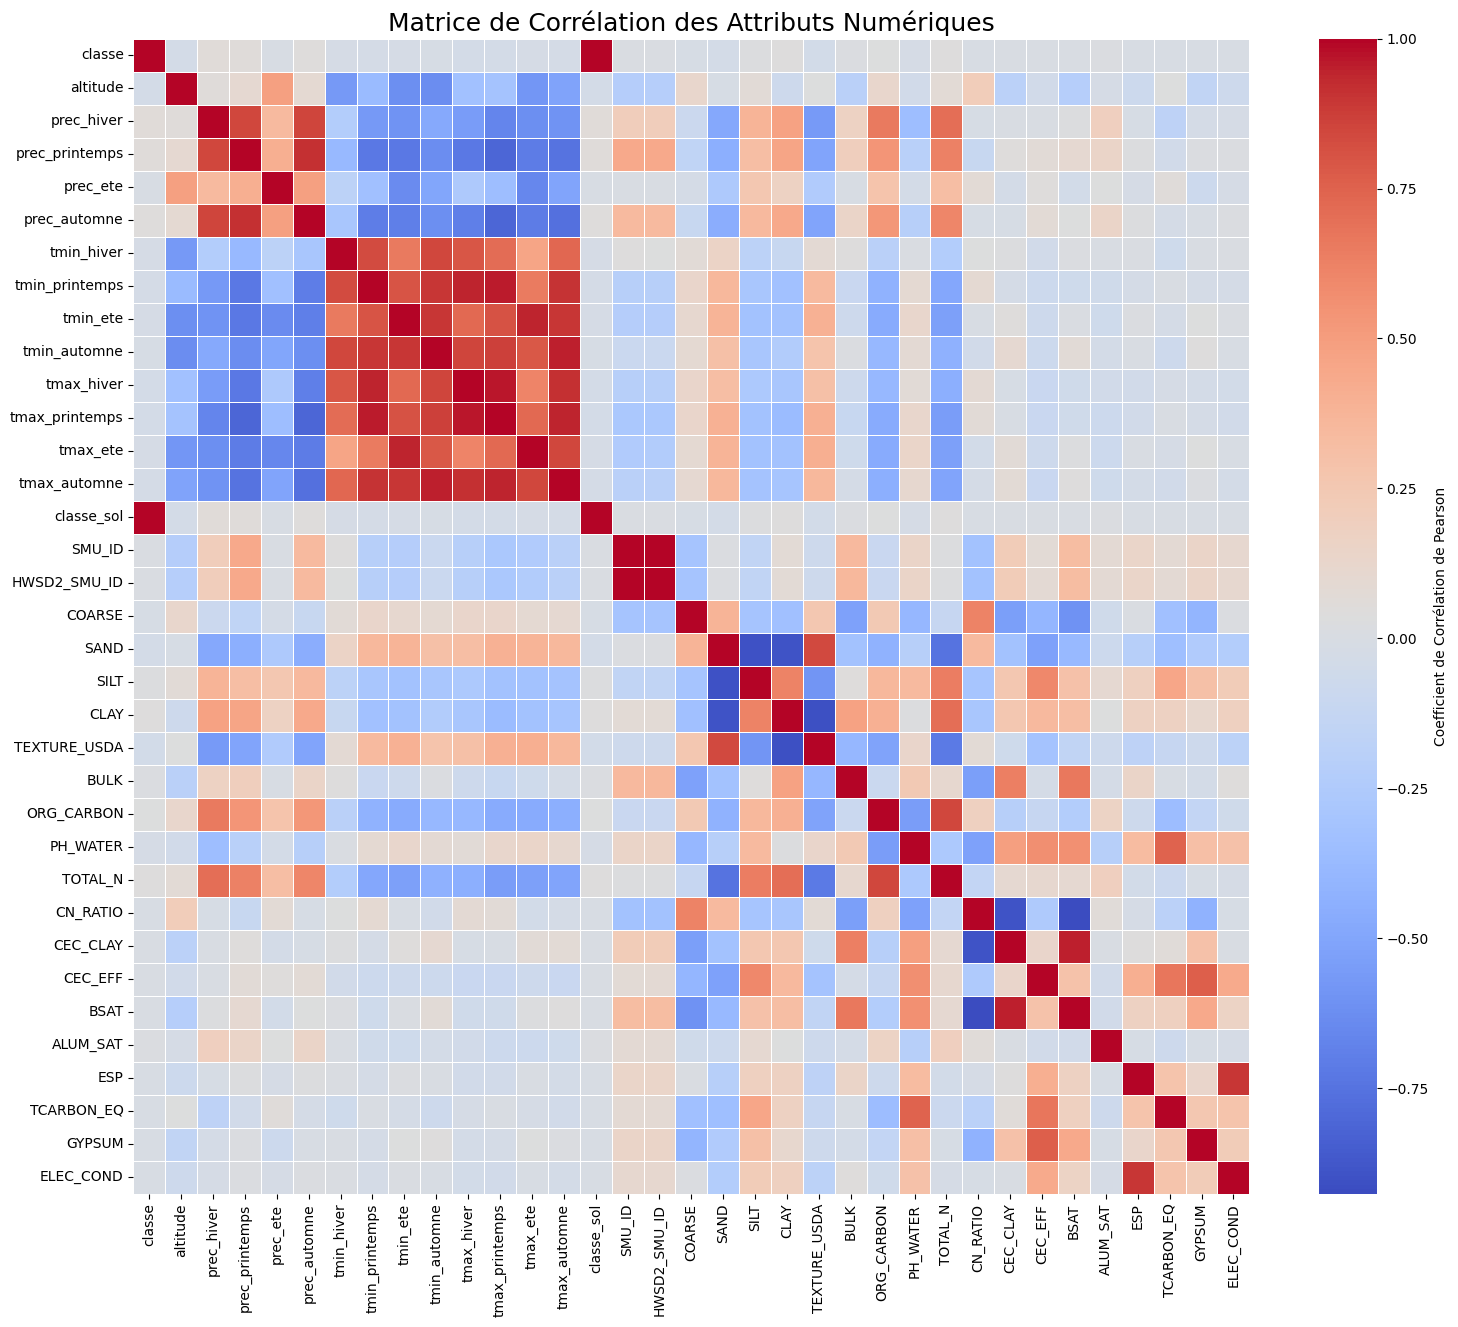


--- Paires d'Attributs Fortement Correlés (Seuil > 0.90) ---
|                                      | 0        |
|:-------------------------------------|:---------|
| ('HWSD2_SMU_ID', 'SMU_ID')           | 0.994123 |
| ('tmax_printemps', 'tmax_hiver')     | 0.964351 |
| ('tmin_printemps', 'tmax_printemps') | 0.961603 |
| ('tmax_automne', 'tmin_automne')     | 0.951729 |
| ('BSAT', 'CEC_CLAY')                 | 0.951444 |
| ('tmax_automne', 'tmax_printemps')   | 0.94705  |
| ('tmax_ete', 'tmin_ete')             | 0.947019 |
| ('tmin_printemps', 'tmax_hiver')     | 0.944778 |
| ('prec_printemps', 'prec_automne')   | 0.913228 |
| ('tmax_automne', 'tmax_hiver')       | 0.91317  |
| ('tmin_printemps', 'tmax_automne')   | 0.906855 |
| ('ESP', 'ELEC_COND')                 | 0.901634 |
| ('tmin_automne', 'tmin_ete')         | 0.901031 |

💡 Action Recommandée : Pour chaque paire listée, conservez l'attribut le plus pertinent et supprimez l'autre.


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# 🛑 Assurez-vous d'utiliser le chemin du fichier final propre et imputé
CHEMIN_FICHIER_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_FINAL.csv'
# --------------------

try:
    # 1. Chargement du DataFrame
    df = pd.read_csv(CHEMIN_FICHIER_FINAL)
    
    # 2. Exclure les colonnes non numériques et les clés
    # Sélectionner uniquement les colonnes numériques pour la matrice
    df_numerique = df.select_dtypes(include=[np.number]).copy()
    
    # Supprimer les clés pour la corrélation interne des features
    if 'latitude' in df_numerique.columns and 'longitude' in df_numerique.columns:
        df_numerique = df_numerique.drop(columns=['latitude', 'longitude'])

    # 3. Calculer la Matrice de Corrélation de Pearson
    matrice_correlation = df_numerique.corr()
    
    # 4. Création du Plot (Heatmap)
    plt.figure(figsize=(18, 15))
    
    # Utilisation de Seaborn pour une visualisation claire
    sns.heatmap(
        matrice_correlation,
        annot=False, # Définir à True pour afficher les nombres, mais peut surcharger
        cmap='coolwarm',
        fmt=".2f",
        linewidths=.5,
        cbar_kws={'label': 'Coefficient de Corrélation de Pearson'}
    )
    
    plt.title('Matrice de Corrélation des Attributs Numériques', fontsize=18)
    plt.show() # Affiche le graphique

    # 5. Identification des Corrélation Élevées pour la Suppression
    
    seuil_multicolinearite = 0.90
    corr_elevee = matrice_correlation.unstack()
    
    # Filtrer pour ne garder que les corrélations élevées (hors la corrélation d'une variable avec elle-même)
    corr_filtree = corr_elevee[(corr_elevee >= seuil_multicolinearite) & (corr_elevee < 1.0)]
    
    print("\n--- Paires d'Attributs Fortement Correlés (Seuil > 0.90) ---")
    if corr_filtree.empty:
        print("✅ Aucune paire d'attributs n'a une corrélation supérieure à 0.90.")
    else:
        # Nettoyer les doublons (A vs B)
        corr_resultats = corr_filtree.sort_values(ascending=False).drop_duplicates()
        print(corr_resultats.to_markdown(numalign="left", stralign="left"))
        print("\n💡 Action Recommandée : Pour chaque paire listée, conservez l'attribut le plus pertinent et supprimez l'autre.")

# Ceci est le bloc EXCEPT qui manquait ou était mal positionné, causant la SyntaxError
except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER_FINAL}")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue lors du calcul de la corrélation : {e}")

In [18]:
import pandas as pd
import numpy as np

# --- CONFIGURATION MISE À JOUR ---
# Fichier d'entrée : Le jeu de données final et renommé
CHEMIN_FICHIER_ENTREE = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_FINAL.csv' 
# Fichier de sortie : Le jeu de données prêt pour l'entraînement, réduit
CHEMIN_FICHIER_SORTIE = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_reduit.csv'

SEUIL_CORRELATION = 0.90 
# --------------------------------

def supprimer_variables_multicolineaires(df, seuil):
    """
    Identifie et supprime les variables numériques fortement corrélées
    (multicolinéarité) en gardant celle qui a la plus grande variance.
    """
    
    # 1. Sélectionner uniquement les colonnes numériques
    colonnes_a_analyser = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclure la variable cible et les clés pour l'analyse de multicolinéarité
    colonnes_a_ignorer = ['classe', 'latitude', 'longitude']
    for col in colonnes_a_ignorer:
        if col in colonnes_a_analyser:
            colonnes_a_analyser.remove(col)
            
    df_numerique = df[colonnes_a_analyser]

    # 2. Calculer la matrice de corrélation
    matrice_correlation = df_numerique.corr().abs()
    
    # Structure pour stocker les colonnes à supprimer
    colonnes_a_supprimer = set()
    
    # 3. Parcourir la matrice (triangle supérieur)
    for i in range(len(matrice_correlation.columns)):
        for j in range(i):
            if matrice_correlation.iloc[i, j] >= seuil:
                colonne_i = matrice_correlation.columns[i]
                colonne_j = matrice_correlation.columns[j]
                
                # Critère de suppression : supprimer la variable avec la plus petite variance
                var_i = df_numerique[colonne_i].var()
                var_j = df_numerique[colonne_j].var()
                
                if var_i < var_j:
                    colonnes_a_supprimer.add(colonne_i)
                else:
                    colonnes_a_supprimer.add(colonne_j)
                    
    return list(colonnes_a_supprimer)

try:
    df = pd.read_csv(CHEMIN_FICHIER_ENTREE)
    
    # Appliquer la fonction de suppression
    colonnes_redondantes = supprimer_variables_multicolineaires(df.copy(), SEUIL_CORRELATION)
    
    if not colonnes_redondantes:
        print(f"\n✅ Aucune corrélation supérieure à {SEUIL_CORRELATION} trouvée. Aucune colonne n'a été supprimée.")
        df.to_csv(CHEMIN_FICHIER_SORTIE, index=False)
    else:
        # Suppression des colonnes identifiées
        df_reduit = df.drop(columns=colonnes_redondantes)
        
        # Sauvegarde du nouveau DataFrame
        df_reduit.to_csv(CHEMIN_FICHIER_SORTIE, index=False)
        
        print("\n--- Résultat de l'Élagage des Features ---")
        print(f"Seuil de corrélation : > {SEUIL_CORRELATION}")
        print(f"Colonnes supprimées ({len(colonnes_redondantes)}) :")
        print(colonnes_redondantes)
        print(f"\nDimensions du jeu de données AVANT : {df.shape}")
        print(f"Dimensions du jeu de données APRÈS : {df_reduit.shape}")
        print(f"\n✅ Le jeu de données réduit est sauvegardé à : {CHEMIN_FICHIER_SORTIE}")

except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER_ENTREE}")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")


--- Résultat de l'Élagage des Features ---
Seuil de corrélation : > 0.9
Colonnes supprimées (11) :
['HWSD2_SMU_ID', 'tmax_automne', 'CN_RATIO', 'tmax_hiver', 'tmin_automne', 'ELEC_COND', 'tmin_printemps', 'TEXTURE_USDA', 'tmin_ete', 'BSAT', 'prec_printemps']

Dimensions du jeu de données AVANT : (2490258, 39)
Dimensions du jeu de données APRÈS : (2490258, 28)

✅ Le jeu de données réduit est sauvegardé à : C:\Users\hp\Desktop\TPs\DataMining\csv_final\dataset_final_reduit.csv


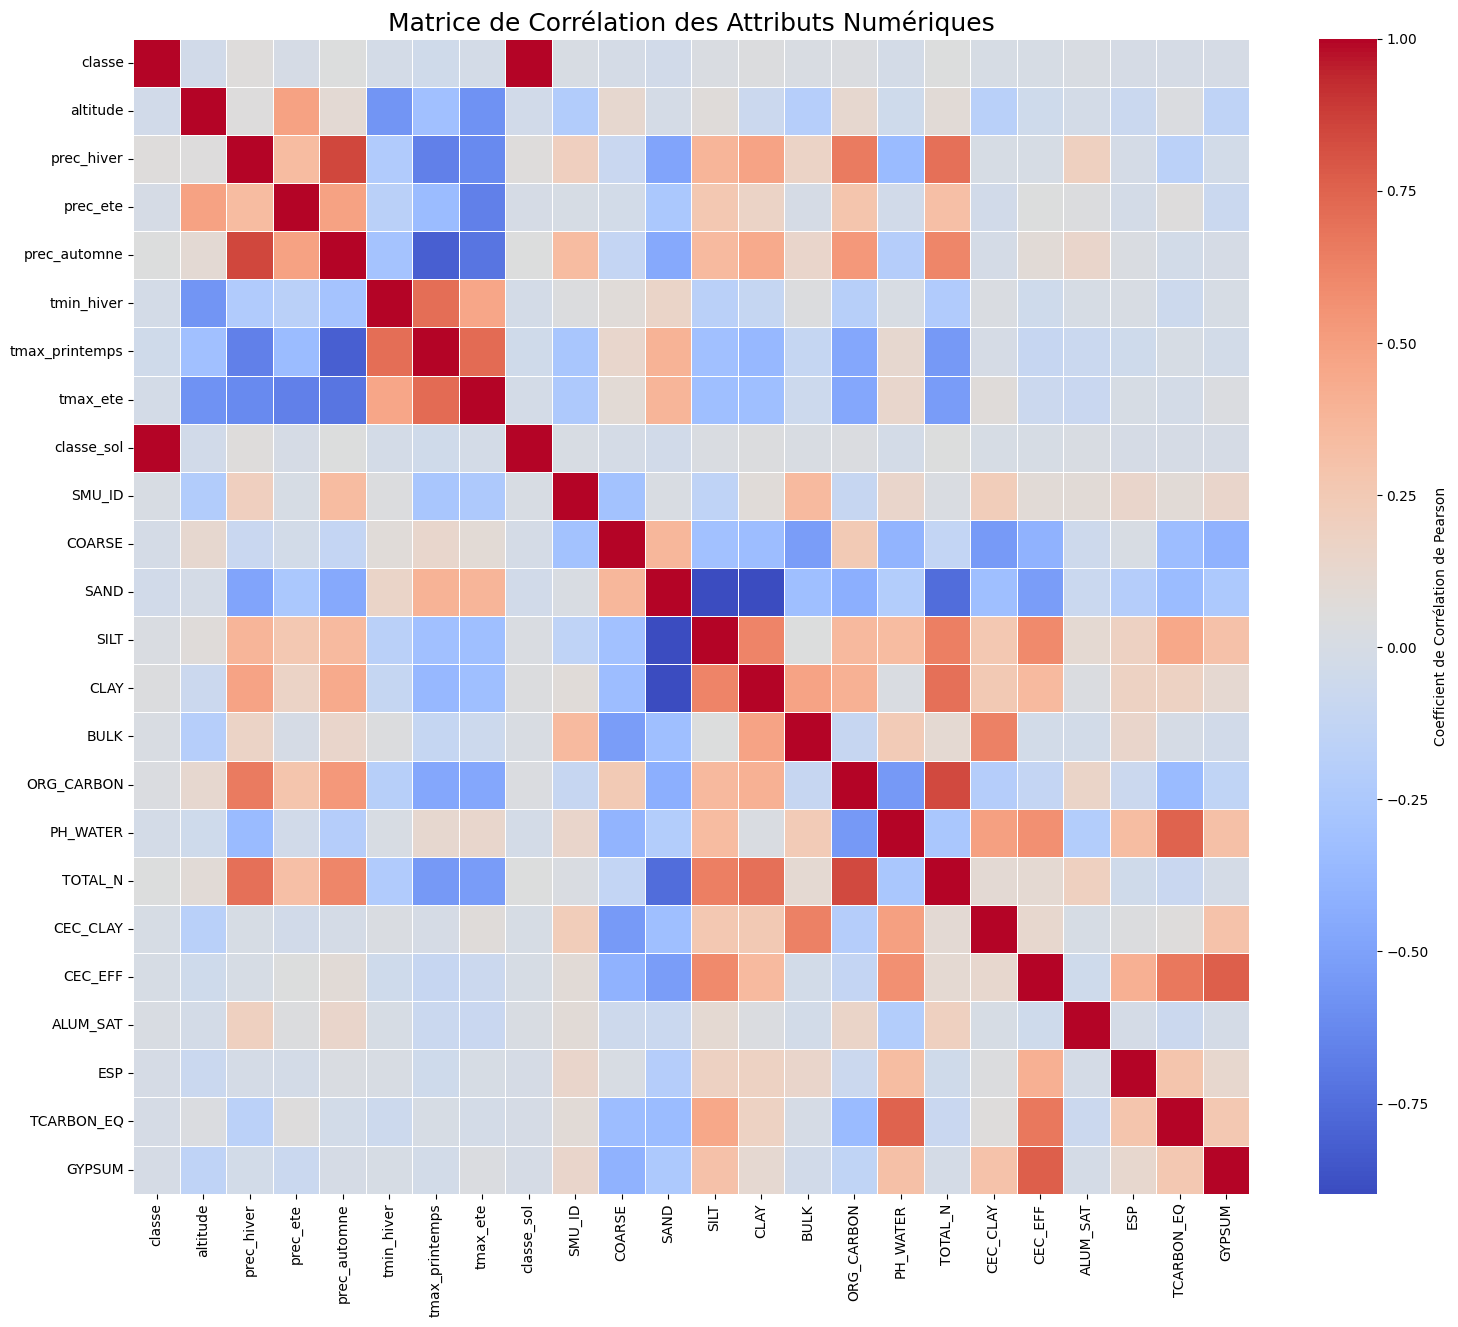


--- Paires d'Attributs Fortement Correlés (Seuil > 0.90) ---
✅ Aucune paire d'attributs n'a une corrélation supérieure à 0.90.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# 🛑 Assurez-vous d'utiliser le chemin du fichier final propre et imputé
CHEMIN_FICHIER_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_reduitimport pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION MISE À JOUR ---
# Fichier à analyser : Le jeu de données final, nettoyé (avant réduction)
CHEMIN_FICHIER_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_FINAL_classe_unique.csv'
# --------------------------------

try:
    # 1. Chargement du DataFrame
    df = pd.read_csv(CHEMIN_FICHIER_FINAL)
    
    # 2. Exclure les colonnes non numériques et les clés
    df_numerique = df.select_dtypes(include=[np.number]).copy()
    
    # Supprimer les clés pour la corrélation interne des features
    if 'latitude' in df_numerique.columns and 'longitude' in df_numerique.columns:
        df_numerique = df_numerique.drop(columns=['latitude', 'longitude'])

    # 3. Calculer la Matrice de Corrélation de Pearson
    matrice_correlation = df_numerique.corr()
    
    # 4. Création du Plot (Heatmap) avec annotations
    
    # Augmentation de la taille pour lire les nombres (ajustez si nécessaire)
    plt.figure(figsize=(22, 18)) 
    
    sns.heatmap(
        matrice_correlation,
        annot=True,     # <--- AFFICHAGE DES NOMBRES (ANNOTATIONS)
        fmt=".2f",      # Formatage des nombres à deux décimales
        cmap='coolwarm',
        linewidths=.5,
        cbar_kws={'label': 'Coefficient de Corrélation de Pearson'}
    )
    
    plt.title('Matrice de Corrélation des Attributs Numériques avec Coefficients', fontsize=20)
    plt.show() # Affiche le graphique

    # 5. Identification des Corrélation Élevées (pour référence)
    seuil_multicolinearite = 0.90
    corr_elevee = matrice_correlation.unstack()
    
    # Filtrer pour ne garder que les corrélations élevées (hors la corrélation d'une variable avec elle-même)
    corr_filtree = corr_elevee[(corr_elevee >= seuil_multicolinearite) & (corr_elevee < 1.0)]
    
    print("\n--- Paires d'Attributs Fortement Correlés (Seuil > 0.90) ---")
    if corr_filtree.empty:
        print("✅ Aucune paire d'attributs n'a une corrélation supérieure à 0.90.")
    else:
        corr_resultats = corr_filtree.sort_values(ascending=False).drop_duplicates()
        print(corr_resultats.to_markdown(numalign="left", stralign="left"))
        print("\n💡 Utilisez les nombres du graphique et cette liste pour choisir quelle variable supprimer (gardez celle qui a la meilleure corrélation avec 'classe').")

except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER_FINAL}")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue lors du calcul de la corrélation : {e}").csv'
# --------------------

try:
    # 1. Chargement du DataFrame
    df = pd.read_csv(CHEMIN_FICHIER_FINAL)
    
    # 2. Exclure les colonnes non numériques et les clés
    # Sélectionner uniquement les colonnes numériques pour la matrice
    df_numerique = df.select_dtypes(include=[np.number]).copy()
    
    # Supprimer les clés pour la corrélation interne des features
    if 'latitude' in df_numerique.columns and 'longitude' in df_numerique.columns:
        df_numerique = df_numerique.drop(columns=['latitude', 'longitude'])

    # 3. Calculer la Matrice de Corrélation de Pearson
    matrice_correlation = df_numerique.corr()
    
    # 4. Création du Plot (Heatmap)
    plt.figure(figsize=(18, 15))
    
    # Utilisation de Seaborn pour une visualisation claire
    sns.heatmap(
        matrice_correlation,
        annot=False, # Définir à True pour afficher les nombres, mais peut surcharger
        cmap='coolwarm',
        fmt=".2f",
        linewidths=.5,
        cbar_kws={'label': 'Coefficient de Corrélation de Pearson'}
    )
    
    plt.title('Matrice de Corrélation des Attributs Numériques', fontsize=18)
    plt.show() # Affiche le graphique

    # 5. Identification des Corrélation Élevées pour la Suppression
    
    seuil_multicolinearite = 0.90
    corr_elevee = matrice_correlation.unstack()
    
    # Filtrer pour ne garder que les corrélations élevées (hors la corrélation d'une variable avec elle-même)
    corr_filtree = corr_elevee[(corr_elevee >= seuil_multicolinearite) & (corr_elevee < 1.0)]
    
    print("\n--- Paires d'Attributs Fortement Correlés (Seuil > 0.90) ---")
    if corr_filtree.empty:
        print("✅ Aucune paire d'attributs n'a une corrélation supérieure à 0.90.")
    else:
        # Nettoyer les doublons (A vs B)
        corr_resultats = corr_filtree.sort_values(ascending=False).drop_duplicates()
        print(corr_resultats.to_markdown(numalign="left", stralign="left"))
        print("\n💡 Action Recommandée : Pour chaque paire listée, conservez l'attribut le plus pertinent et supprimez l'autre.")

# Ceci est le bloc EXCEPT qui manquait ou était mal positionné, causant la SyntaxError
except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER_FINAL}")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue lors du calcul de la corrélation : {e}")

In [23]:
df=pd.read_csv(r"C:\Users\hp\Desktop\TPs\DataMining\csv_final\dataset_final_reduit.csv")
dfa=df.drop(columns='classe_sol')
dfa.to_csv(r"C:\Users\hp\Desktop\TPs\DataMining\csv_final\dataset_final_reduit.csv",index=False)

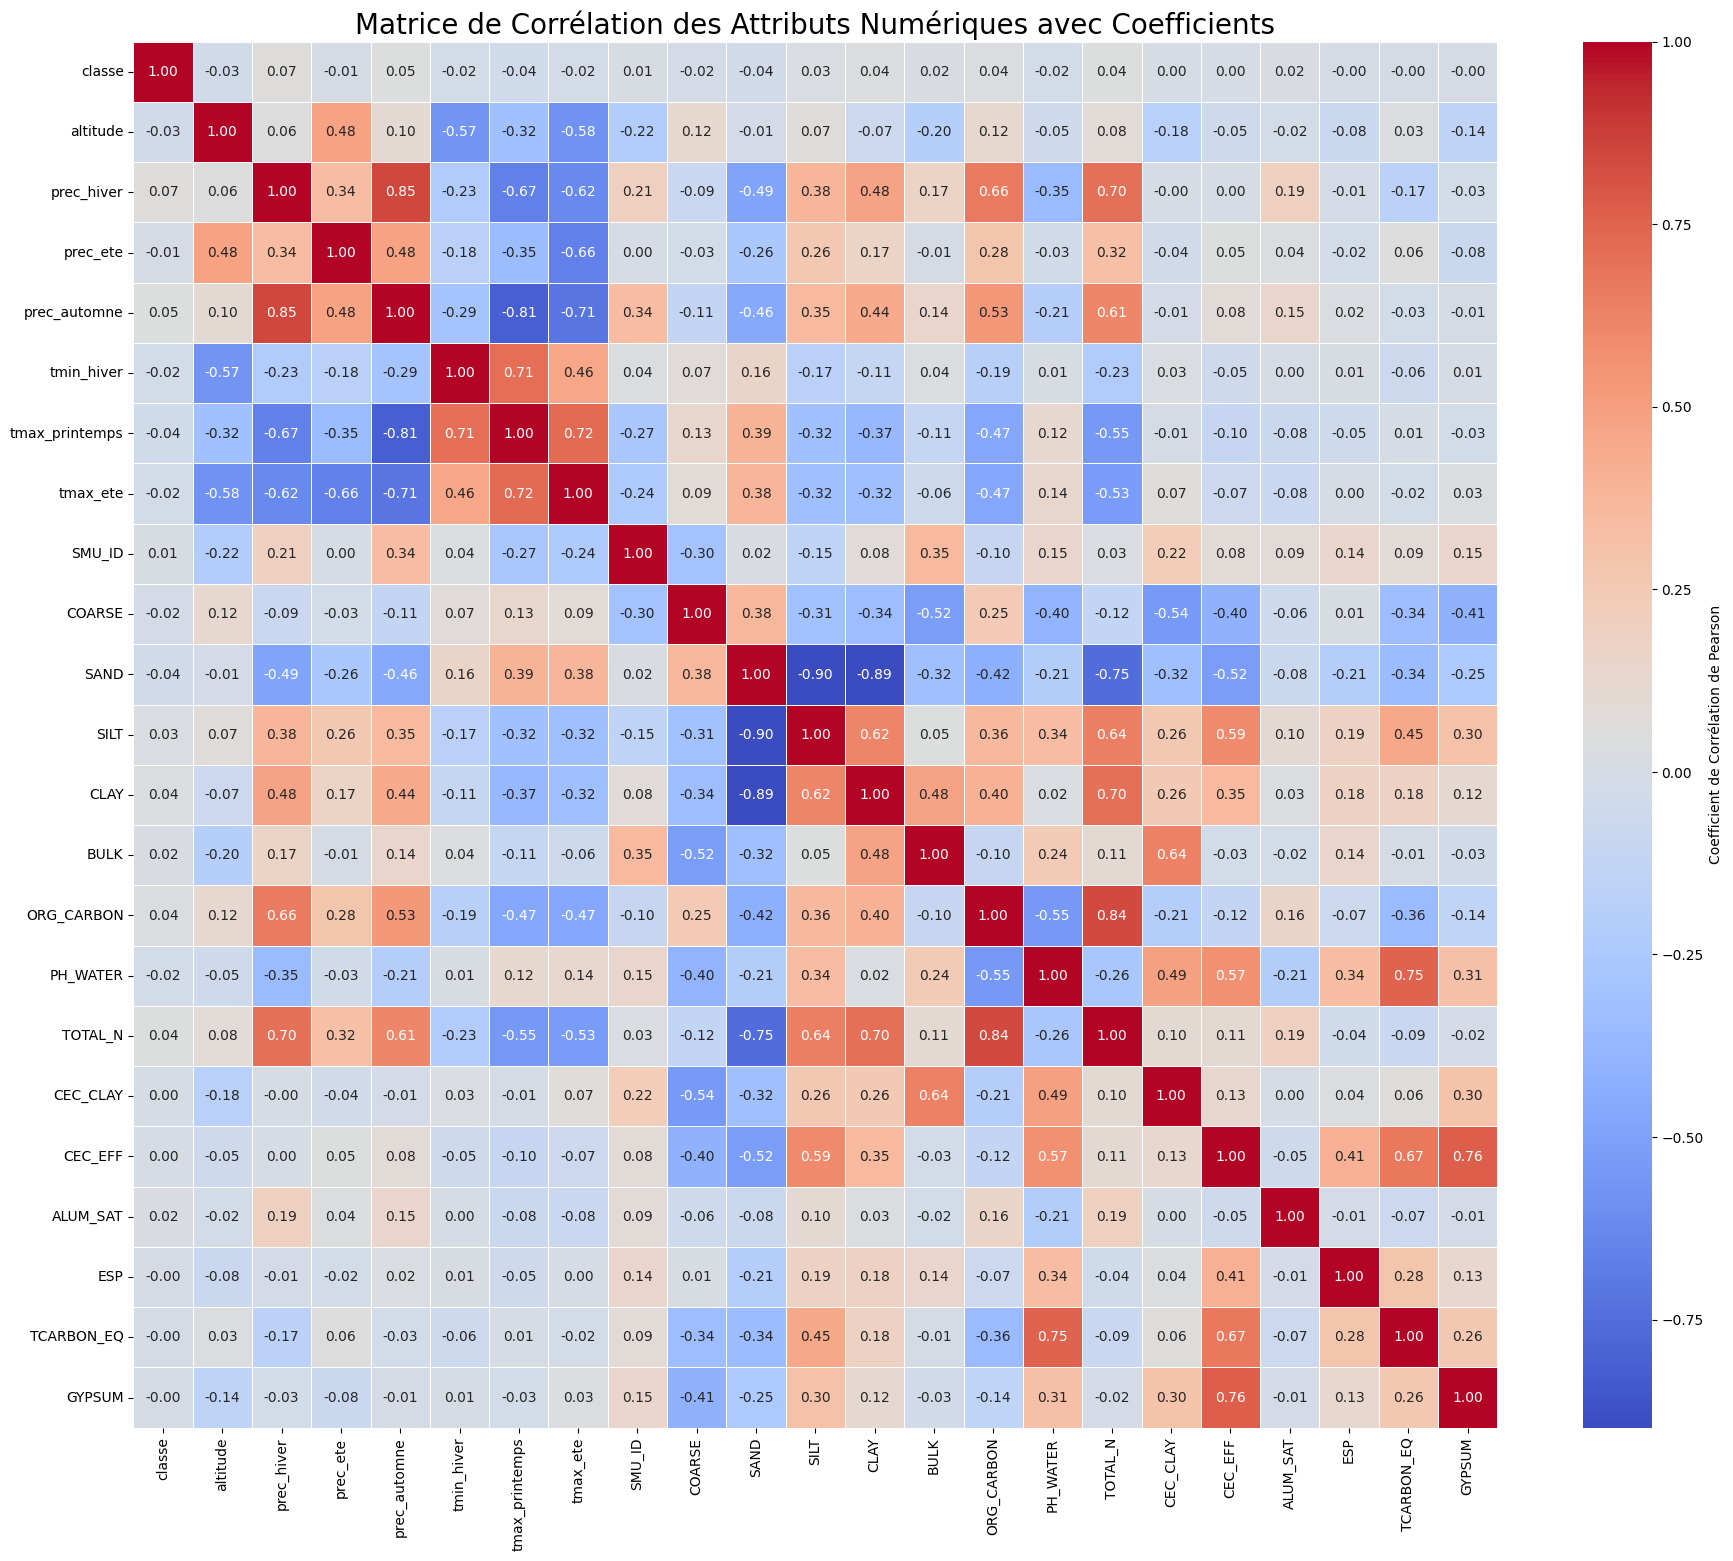


--- Paires d'Attributs Fortement Correlés (Seuil > 0.90) ---
✅ Aucune paire d'attributs n'a une corrélation supérieure à 0.90.


In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION MISE À JOUR ---
# Fichier à analyser : Le jeu de données final, nettoyé (avant réduction)
CHEMIN_FICHIER_FINAL = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\dataset_final_reduit.csv'
# --------------------------------

try:
    # 1. Chargement du DataFrame
    df = pd.read_csv(CHEMIN_FICHIER_FINAL)
    
    # 2. Exclure les colonnes non numériques et les clés
    df_numerique = df.select_dtypes(include=[np.number]).copy()
    
    # Supprimer les clés pour la corrélation interne des features
    if 'latitude' in df_numerique.columns and 'longitude' in df_numerique.columns:
        df_numerique = df_numerique.drop(columns=['latitude', 'longitude'])

    # 3. Calculer la Matrice de Corrélation de Pearson
    matrice_correlation = df_numerique.corr()
    
    # 4. Création du Plot (Heatmap) avec annotations
    
    # Augmentation de la taille pour lire les nombres (ajustez si nécessaire)
    plt.figure(figsize=(22, 18)) 
    
    sns.heatmap(
        matrice_correlation,
        annot=True,     # <--- AFFICHAGE DES NOMBRES (ANNOTATIONS)
        fmt=".2f",      # Formatage des nombres à deux décimales
        cmap='coolwarm',
        linewidths=.5,
        cbar_kws={'label': 'Coefficient de Corrélation de Pearson'}
    )
    
    plt.title('Matrice de Corrélation des Attributs Numériques avec Coefficients', fontsize=20)
    plt.show() # Affiche le graphique

    # 5. Identification des Corrélation Élevées (pour référence)
    seuil_multicolinearite = 0.90
    corr_elevee = matrice_correlation.unstack()
    
    # Filtrer pour ne garder que les corrélations élevées (hors la corrélation d'une variable avec elle-même)
    corr_filtree = corr_elevee[(corr_elevee >= seuil_multicolinearite) & (corr_elevee < 1.0)]
    
    print("\n--- Paires d'Attributs Fortement Correlés (Seuil > 0.90) ---")
    if corr_filtree.empty:
        print("✅ Aucune paire d'attributs n'a une corrélation supérieure à 0.90.")
    else:
        corr_resultats = corr_filtree.sort_values(ascending=False).drop_duplicates()
        print(corr_resultats.to_markdown(numalign="left", stralign="left"))
        print("\n💡 Utilisez les nombres du graphique et cette liste pour choisir quelle variable supprimer (gardez celle qui a la meilleure corrélation avec 'classe').")

except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER_FINAL}")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue lors du calcul de la corrélation : {e}")

In [1]:
import pandas as pd

df=pd.read_csv(r"C:\Users\hp\Desktop\TPs\DataMining\csv_final\dataset_FINAL.csv")
df.head()
df.shape

(2490258, 27)